In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

In [2]:
# Load data
df = pd.read_csv('./USvideos_dateFormatted.csv')
print(df.shape)
df.head(3)

(40949, 22)


,video_id,trending_date,title,channel_title,publish_date,category_id,publish_time,tags,views,likes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,hour,min,sec,views in hour
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13,22,17:13:01,SHANtell martin,748374,57527,...,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,17,13,1,1.603781e+06
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,2017-11-13,24,07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,...,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment,7,30,0,4.147581e+06
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,2017-11-12,23,19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,...,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,19,5,24,1.467202e+06


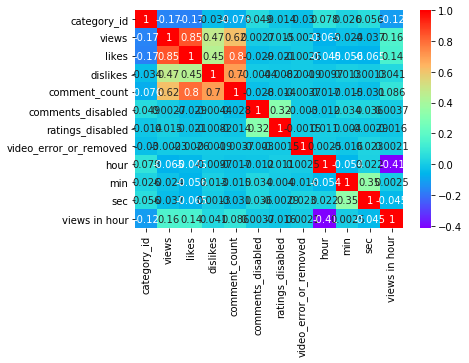

In [3]:
corr = df.corr()
plt.Figure(figsize=(16,10))
sns.heatmap(corr, annot=True,cmap='rainbow')

In [4]:
cor = df.corr()
cor_target = abs(cor['likes'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

views            0.849177
likes            1.000000
dislikes         0.447186
comment_count    0.803057
Name: likes, dtype: float64

In [5]:
df = df[['views','dislikes','comment_count','likes']]

In [6]:
features = df[['views','dislikes','comment_count']]
target = df.likes

In [7]:
# creats extra features
poly = PolynomialFeatures(2,interaction_only=True,include_bias = False)
features_e = poly.fit_transform(features)
cols = poly.get_feature_names(features.columns)
features_e = pd.DataFrame(features_e,columns=cols)
print('before:   features shape',features.shape)
print('after： features_e shape',features_e.shape)
features_e.head(3)

before:   features shape (40949, 3)
after： features_e shape (40949, 6)


,views,dislikes,comment_count,views dislikes,views comment_count,dislikes comment_count
0,748374.0,2966.0,15954.0,2.219677e+09,1.193956e+10,47319564.0
1,2418783.0,6146.0,12703.0,1.486584e+10,3.072580e+10,78072638.0
2,3191434.0,5339.0,8181.0,1.703907e+10,2.610912e+10,43678359.0


In [8]:
# standardize features
features_e = (features_e - features_e.mean())/features_e.std()
features_e.head(3)

,views,dislikes,comment_count,views dislikes,views comment_count,dislikes comment_count
0,-0.218067,-0.025677,0.200564,-0.040953,-0.056854,-0.027302
1,0.007844,0.083866,0.113709,-0.036153,-0.050885,-0.026175
2,0.112339,0.056067,-0.007101,-0.035328,-0.052352,-0.027436


In [9]:
# create bias column of ones
features_e['bias'] = 1
features_e.head(3)

,views,dislikes,comment_count,views dislikes,views comment_count,dislikes comment_count,bias
0,-0.218067,-0.025677,0.200564,-0.040953,-0.056854,-0.027302,1
1,0.007844,0.083866,0.113709,-0.036153,-0.050885,-0.026175,1
2,0.112339,0.056067,-0.007101,-0.035328,-0.052352,-0.027436,1


In [10]:
features_e.describe().T[['mean','std']]

,mean,std
views,3.319092e-16,1.0
dislikes,-1.362774e-16,1.0
comment_count,5.906693e-16,1.0
views dislikes,5.766252e-17,1.0
views comment_count,-3.683211e-16,1.0
dislikes comment_count,-1.485539e-16,1.0
bias,1.000000e+00,0.0


# Linear Regression

In [11]:
lr = LinearRegression(fit_intercept=False)
cv_results = cross_validate(lr,
                           features_e,
                           target,
                           return_train_score=True)
R2_train = cv_results['train_score'].mean()
R2_test = cv_results['test_score'].mean()
print('R2 train', R2_train.round(3))
print('R2 test',R2_test.round(3))

R2 train 0.89
R2 test 0.826


In [12]:
# coefficients
lr.fit(features_e,target)
coef = pd.Series(lr.coef_, index=features_e.columns)
print(coef.sort_values(ascending=False).head(100))

comment_count             176941.469497
views                     123804.106227
bias                       74266.702435
views dislikes             36687.505982
views comment_count       -34700.651073
dislikes comment_count    -45883.427066
dislikes                  -47631.052571
dtype: float64


# KNN Regressor

In [13]:
(df_train, df_test) = train_test_split(df,train_size=0.8,test_size=0.2,shuffle=True,random_state=0)

In [14]:
#select features and target
features_train = df_train.iloc[:,0:-1]
features_test = df_test.iloc[:,0:-1]
targets_train = df_train.iloc[:,-1]
targets_test = df_test.iloc[:,-1]

In [15]:
# standardize
features_train = scale(features_train)
features_test = scale(features_test)

In [16]:
num_neighbors = []
R2_train = []
R2_test = []
for K in np.arange(100)+1:
    knn = KNeighborsRegressor(n_neighbors=K)
    knn.fit(features_train, targets_train)
    num_neighbors.append(K)
    R2_train.append(knn.score(features_train, targets_train))
    R2_test.append(knn.score(features_test, targets_test))

errors = pd.DataFrame()
errors['num_neighbors'] = num_neighbors
errors['train R2'] = R2_train
errors['test R2'] = R2_test
errors.head(10)

,num_neighbors,train R2,test R2
0,1,1.000000,0.907707
1,2,0.984913,0.928401
2,3,0.978878,0.937696
3,4,0.972810,0.938187
4,5,0.969361,0.939103
5,6,0.965714,0.938608
6,7,0.962332,0.939611
7,8,0.958758,0.938381
8,9,0.954588,0.937087
9,10,0.951330,0.935472


Text(0, 0.5, 'R2')

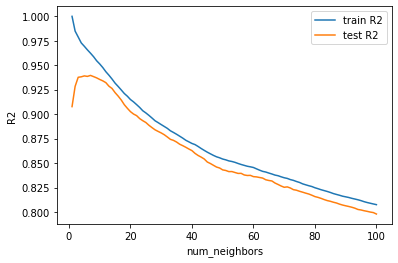

In [17]:
ax1 = errors.plot.line(x = 'num_neighbors', y = 'train R2')
errors.plot.line(x = 'num_neighbors', y = 'test R2', ax = ax1)
plt.ylabel('R2')

In [18]:
print('      Max test R-sqr = ', round(errors['test R2'].max(),2))
ix = errors['test R2'].idxmax()
print('optimal n_neighbors =',errors.num_neighbors[ix])

      Max test R-sqr =  0.94
optimal n_neighbors = 7


### KNN: Check R-square

In [19]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(features_train, targets_train)
yh = knn.predict(features_train)
y = targets_train
mse_knn = ((y-yh)**2).mean()
mse_knn

1946683849.376646

In [20]:
b = y.mean()
mse_bias = ((y-b)**2).mean()
mse_bias

51680545562.37503

In [21]:
R2 = 1 - mse_knn/mse_bias
round(R2,7)

0.9623324

# Decision Tree

### Determine the depth that maximize the test R2


best alpha = {'max_depth': 7}   test R2 = 0.784


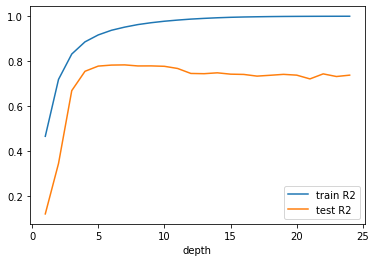

In [42]:
grid = {'max_depth':np.arange(1,25)}

tree = DecisionTreeRegressor()
treeCV = GridSearchCV(tree,param_grid=grid,return_train_score=True)
treeCV.fit(features,target)

print()
print('best alpha =',treeCV.best_params_, '  test R2 =',treeCV.best_score_.round(3))

results = pd.DataFrame()
results['depth'] = grid['max_depth']
results['train R2'] = treeCV.cv_results_['mean_train_score']
results['test R2']  = treeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train R2')
results.plot.line(x='depth',y='test R2',ax=ax1)

#### Draw the tree

In [43]:
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(features,target)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

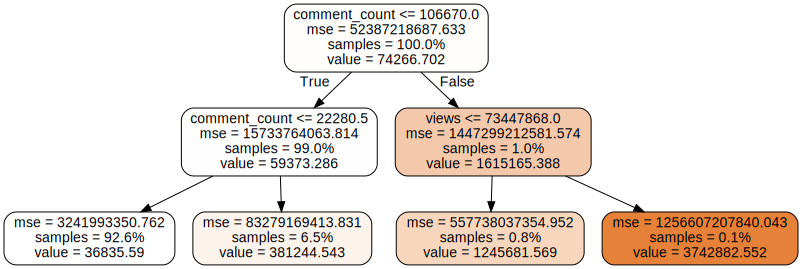

In [44]:
dot_data = export_graphviz(tree,
                          out_file=None,
                          feature_names= features.columns,
                          proportion = True,
                          impurity=True,
                          filled=True,
                          rounded= True)
graph = graphviz.Source(dot_data)
graph

In [45]:
graph.render('LikesDecisionTree3')

'LikesDecisionTree3.pdf'